In [8]:
pip install scipy arviz numpy matplotlib pymc3 seaborn pandas


     |████████████████████████████████| 27.7MB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 1.4MB 2.3MB/s eta 0:00:01
     |████████████████████████████████| 860kB 2.5MB/s eta 0:00:01
     |████████████████████████████████| 215kB 2.5MB/s eta 0:00:01
     |████████████████████████████████| 604kB 2.3MB/s eta 0:00:01
     |████████████████████████████████| 6.4MB 2.4MB/s eta 0:00:01
     |████████████████████████████████| 2.8MB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 235kB 2.2MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 563kB 2.5MB/s eta 0:00:01
  Stored in directory: /Users/stewart/Library/Caches/pip/wheels/88/fb/be/483910ff7e9f703f30a10605ad7605f3316493875c86637014
Successfully built theano
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install sklearn

     |████████████████████████████████| 10.5MB 6.1MB/s eta 0:00:01
     |████████████████████████████████| 286kB 1.2MB/s eta 0:00:01
  Stored in directory: /Users/stewart/Library/Caches/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [16]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing
print('Running on PyMC3 v{}'.format(pm.__version__))
data = pd.read_csv('renfe.csv')
data.drop(data.columns[[0]], axis = 1)
data = data.sample(frac=0.01, random_state=99)
data.head(3)

Running on PyMC3 v3.7


,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
4738,2019-04-17 08:03:35,VALENCIA,MADRID,2019-05-21 08:00:00,2019-05-21 09:47:00,AVE,33.65,Turista,Promo
8722,2019-05-09 07:12:41,MADRID,BARCELONA,2019-05-25 08:30:00,2019-05-25 11:15:00,AVE,85.10,Turista,Promo
13185,2019-04-24 11:21:26,MADRID,VALENCIA,2019-05-22 17:40:00,2019-05-22 19:20:00,AVE,51.15,Turista,Promo


In [17]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.096899
train_class    0.000000
fare           0.000000
dtype: float64

There are 9.7% of price values missing. Fill them with the mean of fare types

In [18]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

We will now fit and plot a univariate or bivariate kernel density estimate.

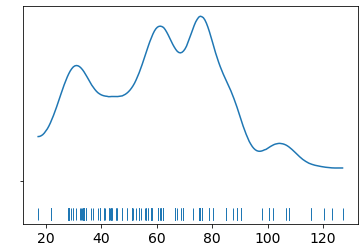

In [19]:
az.plot_kde(data['price'].values, rug=True)
plt.yticks([0], alpha=0);

This is guassian like if you can exclude the positively skewed distribution. For the bayesian analysis we will assume that a gaussian distribution is the proper distribution of the rail tickets.

# Model 
We will perform Gaussian inferences on the ticket price data.

## Instantiating PyMC3 model
* Model specifications in PyMC3 are wrapped in a with-statement. 
### Prior:
* μ, mean of a population. Normal distribution, very wide. If you do not know the possible values of μ, you can set priors reflecting your ignorance. Let's say that train ticket price can not be lower than 0 or higher than 300.
* σ, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution (https://en.wikipedia.org/wiki/Half-normal_distribution). Again, very wide.
### Price Likelihood function
* y is an observed variable representing the data that comes from a normal distribution with the parameters μ and σ.
* Draw 1000 posterior samples using NUTS sampling.